## Cluster Analysis

This script imports the filtered data and runs cluster analysis
filtered_data.csv: rows where userIDs have <3 entries are removed

In [1]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sn
from wordcloud import WordCloud
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.datasets import load_digits
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [2]:
import h2o
from h2o.estimators import H2OGeneralizedLowRankEstimator
from h2o.estimators import H2OKMeansEstimator
import warnings

## Import Endo Data

In [3]:
# Read in filtered data
h2o.init()
file_path = 'data/filtered_data.csv'
data = h2o.import_file(file_path)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_421"; Java(TM) SE Runtime Environment (build 1.8.0_421-b09); Java HotSpot(TM) 64-Bit Server VM (build 25.421-b09, mixed mode)
  Starting server from /Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/6c/xr_8v79n1619p54spnzz7l240000gn/T/tmpjl2a7zta
  JVM stdout: /var/folders/6c/xr_8v79n1619p54spnzz7l240000gn/T/tmpjl2a7zta/h2o_michelle_started_from_python.out
  JVM stderr: /var/folders/6c/xr_8v79n1619p54spnzz7l240000gn/T/tmpjl2a7zta/h2o_michelle_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Europe/Dublin
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.4
H2O_cluster_version_age:,1 month and 8 days
H2O_cluster_name:,H2O_from_python_michelle_hlu127
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.542 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [4]:
#data.columns
#data.head()
data.shape

(26141, 47)

In [5]:
# Specify the columns to be ignored
ignore_columns = ["ID", "date", "datetime", "create_date", "updated_date", "userID", "periodID", "water", "nutrition", "medication", "notes", "other_moods", "other_lifestyles"]
data = data.drop(ignore_columns)
data.shape

(26141, 34)

In [6]:
# Convert columns to categorical 
categorical_columns = ['period', 'sex', 'period_intensity', 'pain_level','backaches', 
                       'bodyaches', 'stomach_cramps', 'joint_pains', 'tender_breasts', 'overall_pain', 'headache',
                       'indigestion', 'bloating','constipation', 'diarrhea','nausea', 'vomiting', 'appetite_loss', 
                       'cravings_salty','cravings_sweet', 'skin_changes', 'acne','tiredness','dizziness',
                       'pins_and_needles','temperature','fever','hot_flashes','short_of_breath','coughing', 'insomnia']

for col in categorical_columns:
    data[col] = data[col].asfactor()

# View the data types of columns to verify
data.types

{'period': 'enum',
 'sex': 'enum',
 'period_intensity': 'enum',
 'pain_level': 'enum',
 'backaches': 'enum',
 'bodyaches': 'enum',
 'stomach_cramps': 'enum',
 'joint_pains': 'enum',
 'tender_breasts': 'enum',
 'overall_pain': 'enum',
 'headache': 'enum',
 'indigestion': 'enum',
 'bloating': 'enum',
 'constipation': 'enum',
 'diarrhea': 'enum',
 'nausea': 'enum',
 'vomiting': 'enum',
 'appetite_loss': 'enum',
 'cravings_salty': 'enum',
 'cravings_sweet': 'enum',
 'skin_changes': 'enum',
 'acne': 'enum',
 'tiredness': 'enum',
 'dizziness': 'enum',
 'pins_and_needles': 'enum',
 'temperature': 'enum',
 'fever': 'enum',
 'hot_flashes': 'enum',
 'short_of_breath': 'enum',
 'coughing': 'enum',
 'insomnia': 'enum',
 'sleep': 'int',
 'weight': 'real',
 'steps': 'int'}

In [7]:
# Specify the data type for each column
loss_by_col = ['Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical',
               'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical',
               'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical',
               'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical',
               'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical',
               'Categorical', 'Categorical', 'Categorical', 'Categorical', 'Categorical',
               'Categorical', 'Quadratic', 'Quadratic', 'Quadratic']


# GLRM Model

#### Generalized Low Rank Model

In [10]:
# Build and train the model
glrm_model = H2OGeneralizedLowRankEstimator(
    k=20,
    loss_by_col=loss_by_col,
    transform="standardize"
)

# Train model
glrm_model.train(training_frame=data)

glrm Model Build progress: |█████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLowRankEstimator : Generalized Low Rank Modeling
Model Key: GLRM_model_python_1723999775634_1


Model Summary: 
    number_of_iterations    final_step_size    final_objective_value
--  ----------------------  -----------------  -----------------------
    352                     9.65947e-05        16860.1

ModelMetricsGLRM: glrm
** Reported on train data. **

MSE: NaN
RMSE: NaN
Sum of Squared Error (Numeric): 371.25999586412877
Misclassification Error (Categorical): 2817.0

Scoring History: 
     timestamp            duration          iterations    step_size               objective
---  -------------------  ----------------  ------------  ----------------------  ------------------
     2024-08-18 17:49:52  5.648 sec         0.0           0.6666666666666666      764733.2285157966
     2024-08-18 17:49:53  6.017 sec         1.0           0.4444444444444444      764733.2285157966
     2024-08-18 17:49:53  6.549 sec         2.0           0.4666666666666667      561101.4439542848
     2024-08-18 17:49:54  7.605 sec         3.0           0.3111111111111111      561101.4439542848
     2024-08-18 17:49:54  7.777 sec         4.0           0.2074074074074074      561101.4439542848
     2024-08-18 17:49:55  7.948 sec         5.0           0.1382716049382716      561101.4439542848
     2024-08-18 17:49:55  8.132 sec         6.0           0.0691358024691358      561101.4439542848
     2024-08-18 17:49:55  8.316 sec         7.0           0.023045267489711932    561101.4439542848
     2024-08-18 17:49:55  8.572 sec         8.0           0.024197530864197528    415643.9613702006
     2024-08-18 17:49:55  8.797 sec         9.0           0.025407407407407406    366049.2033850106
---  ---                  ---               ---           ---                     ---
     2024-08-18 17:51:11  1 min 24.064 sec  342.0         0.00015445810771231013  16861.4892082978
     2024-08-18 17:51:11  1 min 24.250 sec  343.0         0.00016218101309792564  16861.44837025369
     2024-08-18 17:51:11  1 min 24.422 sec  344.0         0.0001081206753986171   16861.44837025369
     2024-08-18 17:51:11  1 min 24.608 sec  345.0         0.00011352670916854795  16860.577092599247
     2024-08-18 17:51:11  1 min 24.793 sec  346.0         0.00011920304462697535  16860.29987748433
     2024-08-18 17:51:12  1 min 24.999 sec  347.0         0.00012516319685832412  16860.2689454962
     2024-08-18 17:51:12  1 min 25.185 sec  348.0         0.00013142135670124032  16860.214760829804
     2024-08-18 17:51:12  1 min 25.375 sec  349.0         0.00013799242453630236  16860.201341345706
     2024-08-18 17:51:12  1 min 25.574 sec  350.0         0.00014489204576311748  16860.114134712414
     2024-08-18 17:51:12  1 min 25.758 sec  351.0         9.659469717541166e-05   16860.114134712414
[352 rows x 6 columns]


[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

In [11]:
# Evaluate model performance on training data
performance = glrm_model.model_performance()
perf = glrm_model.model_performance(data)
perf

ModelMetricsGLRM: glrm
** Reported on test data. **

MSE: NaN
RMSE: NaN
Sum of Squared Error (Numeric): 371.25999586412877
Misclassification Error (Categorical): 2817.0

In [17]:
# Extract the low-rank representation (X)
X = glrm_model._model_json['output']['representation_name']
A_low_rank_rep = h2o.get_frame(X)

# Transform the valid  data to retrieve the new coefficients:
B_glrm_data = glrm_model.transform_frame(data)

In [18]:
A_low_rank_rep.isna().sum()

0.0

# K-means

In [19]:
# Build and train the model:
kmeans_model = H2OKMeansEstimator(k=10,
                                 estimate_k=True,
                                 standardize=False,
                                 seed=1234)

kmeans_model.train(training_frame=A_low_rank_rep,
                  validation_frame=B_glrm_data)

# Eval performance:
perf = kmeans_model.model_performance()
print(perf)

kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%
ModelMetricsClustering: kmeans
** Reported on train data. **

Total Within Cluster Sum of Square Error: 14867.576361717107
Total Sum of Square Error to Grand Mean: 18812.70080729878
Between Cluster Sum of Square Error: 3945.124445581674

Centroid Statistics: 
    centroid    size    within_cluster_sum_of_squares
--  ----------  ------  -------------------------------
    1           2257    497.905
    2           1406    927.553
    3           8791    4865.84
    4           6999    4127.48
    5           6688    4448.8


In [20]:
# Assess k for a range of values

range_clusters = range(2, 8)
wcss = []  # Within-cluster sum of squares
silhouette_scores = []

for n in range_clusters:

    kmeans_model = H2OKMeansEstimator(k=n,
                                 standardize=False,
                                 seed=1234)

    kmeans_model.train(training_frame=A_low_rank_rep,
                  validation_frame=B_glrm_data)
    
    cluster_assignments = kmeans_model.predict(B_glrm_data)
    
    # Convert to pandas DataFrame for silhouette score calculation
    cluster_assignments_df = cluster_assignments.as_data_frame()
    data_df = B_glrm_data.as_data_frame()
    
    # Add cluster assignments to the original data
    data_df['cluster'] = cluster_assignments_df['predict'].astype(int)

    # Calculate WCSS (total within-cluster sum of squares)
    wcss.append(kmeans_model.tot_withinss())
    print(f"Number of clusters: {n}, WCSS: {wcss}")
    
    # Calculate silhouette score
    sil_score = silhouette_score(data_df.drop('cluster', axis=1), data_df['cluster'])
    silhouette_scores.append(sil_score)
    print(f"Number of clusters: {n}, Silhouette Score: {sil_score:.3f}")


kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%


/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Number of clusters: 2, WCSS: [17531.06197225188]
Number of clusters: 2, Silhouette Score: 0.039
kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%


/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Number of clusters: 3, WCSS: [17531.06197225188, 16149.4065852301]
Number of clusters: 3, Silhouette Score: 0.029
kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%


/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Number of clusters: 4, WCSS: [17531.06197225188, 16149.4065852301, 15530.373752078933]
Number of clusters: 4, Silhouette Score: 0.019
kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%


/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Number of clusters: 5, WCSS: [17531.06197225188, 16149.4065852301, 15530.373752078933, 15064.84500690029]
Number of clusters: 5, Silhouette Score: 0.006
kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%


/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Number of clusters: 6, WCSS: [17531.06197225188, 16149.4065852301, 15530.373752078933, 15064.84500690029, 14521.54274398658]
Number of clusters: 6, Silhouette Score: -0.015
kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%
kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%


/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Number of clusters: 7, WCSS: [17531.06197225188, 16149.4065852301, 15530.373752078933, 15064.84500690029, 14521.54274398658, 14337.881376903786]
Number of clusters: 7, Silhouette Score: 0.011


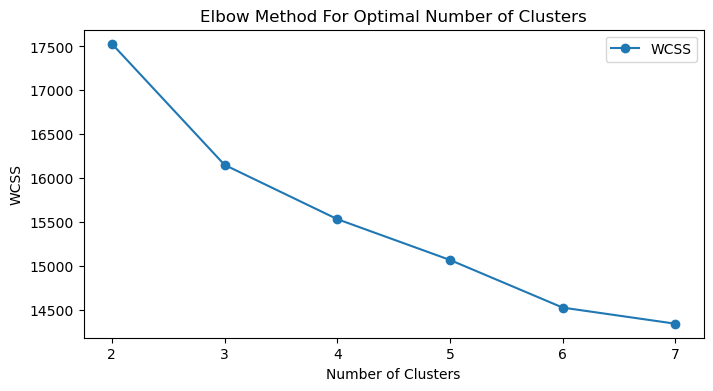

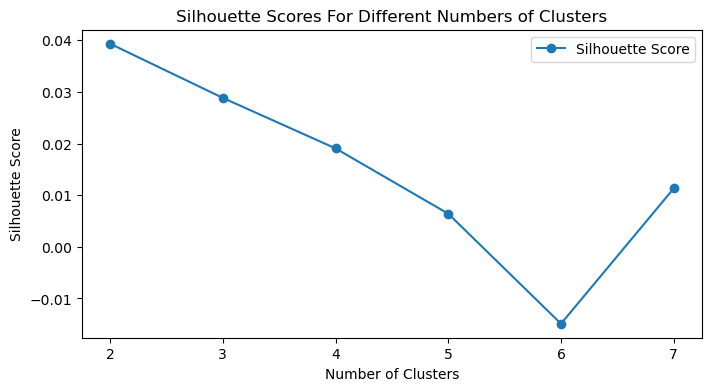

In [21]:
# Plotting the Elbow Method results
plt.figure(figsize=(8, 4))
plt.plot(range_clusters, wcss, marker='o', label='WCSS')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.legend()
plt.show()

# Plotting the Silhouette Analysis results
plt.figure(figsize=(8, 4))
plt.plot(range_clusters, silhouette_scores, marker='o', label='Silhouette Score')
plt.title('Silhouette Scores For Different Numbers of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.legend()
plt.show()


## Best k for k-means

Since 4 phenotypes were found in the previous research, we will look at 4 clusters.
Silhouette Scores are best for 2 clusters, but 4 clusters shows a better ability to distinguish between groups in the data.  

In [35]:
# Build and train the model:
kmeans_model = H2OKMeansEstimator(k=4,
                                 estimate_k=True,
                                 standardize=False,
                                 seed=1234)

kmeans_model.train(training_frame=A_low_rank_rep,
                  validation_frame=B_glrm_data)


kmeans Model Build progress: |███████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OKMeansEstimator : K-means
Model Key: KMeans_model_python_1723999775634_11


Model Summary: 
    number_of_rows    number_of_clusters    number_of_categorical_columns    number_of_iterations    within_cluster_sum_of_squares    total_sum_of_squares    between_cluster_sum_of_squares
--  ----------------  --------------------  -------------------------------  ----------------------  -------------------------------  ----------------------  --------------------------------
    26141             4                     0                                28                      15317.8                          18812.7                 3494.93

ModelMetricsClustering: kmeans
** Reported on train data. **

Total Within Cluster Sum of Square Error: 15316.328369376426
Total Sum of Square Error to Grand Mean: 18812.70080729878
Between Cluster Sum of Square Error: 3496.372437922355

Centroid Statistics: 
    centroid    size    within_cluster_sum_of_squares
--  ----------  ------  -------------------------------
    1           2282    534.414
    2           7196    5180.91
    3           9055    5132.16
    4           7608    4468.84

ModelMetricsClustering: kmeans
** Reported on validation data. **

Total Within Cluster Sum of Square Error: 316852.8856151913
Total Sum of Square Error to Grand Mean: 327637.02987069724
Between Cluster Sum of Square Error: 10784.144255505933

Centroid Statistics: 
    centroid    size    within_cluster_sum_of_squares
--  ----------  ------  -------------------------------
    1           6324    80281
    2           7058    83265.9
    3           4955    59239.9
    4           7804    94066.1

Scoring History: 
     timestamp            duration    iterations    number_of_clusters    number_of_reassigned_observations    within_cluster_sum_of_squares
---  -------------------  ----------  ------------  --------------------  -----------------------------------  -------------------------------
     2024-08-18 17:55:38  0.018 sec   0.0           0.0                   nan                                  nan
     2024-08-18 17:55:38  0.108 sec   1.0           1.0                   26141.0                              53020.70825242542
     2024-08-18 17:55:38  0.114 sec   2.0           1.0                   0.0                                  18812.70080732447
     2024-08-18 17:55:38  0.127 sec   3.0           2.0                   3859.0                               17670.789383772142
     2024-08-18 17:55:38  0.136 sec   4.0           2.0                   716.0                                17443.69026673022
     2024-08-18 17:55:38  0.146 sec   5.0           2.0                   139.0                                17433.250451774227
     2024-08-18 17:55:38  0.156 sec   6.0           2.0                   22.0                                 17432.831412978077
     2024-08-18 17:55:38  0.164 sec   7.0           2.0                   9.0                                  17432.808226414094
     2024-08-18 17:55:38  0.179 sec   8.0           2.0                   1.0                                  17432.806343764547
     2024-08-18 17:55:38  0.202 sec   9.0           3.0                   2121.0                               17113.275842739182
---  ---                  ---         ---           ---                   ---                                  ---
     2024-08-18 17:55:38  0.412 sec   19.0          4.0                   4315.0                               16303.14176069816
     2024-08-18 17:55:38  0.424 sec   20.0          4.0                   3550.0                               15970.258613481292
     2024-08-18 17:55:38  0.444 sec   21.0          4.0                   2353.0                               15630.634882840477
     2024-08-18 17:55:38  0.466 sec   22.0          4.0                   1603.0                               15451.914767023049
     2024-08-18 17:55:38  0.481 sec   23.0          4.0                   1039.0                              

## Predict cluster labels


In [38]:
# Predict cluster labels for the low-rank representation of the data
cluster_labels = kmeans_model.predict(B_glrm_data)
print(cluster_labels.shape)

kmeans prediction progress: |████████████████████████████████████████████████████| (done) 100%
(26141, 1)


In [24]:
# Convert to pandas DataFrame
cluster_labels_df = cluster_labels.as_data_frame()

# Add cluster assignments to the original data
clustered_data = data.as_data_frame()
clustered_data['cluster'] = cluster_labels_df['predict'].astype(int)

# Convert complete data to pandas DataFrame 
data_df = data.as_data_frame()

/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/michelle/opt/anaconda3/lib/python3.12/site-packages/h2o/frame.py:1981: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster co

In [64]:
# Shut down h2o session
h2o.cluster().shutdown()

H2O session _sid_846d closed.


In [40]:
clustered_data.head()

,period,sex,period_intensity,pain_level,backaches,bodyaches,stomach_cramps,joint_pains,tender_breasts,overall_pain,...,temperature,fever,hot_flashes,short_of_breath,coughing,insomnia,sleep,weight,steps,cluster
0,0,0,NaN,NaN,2.0,2.0,1.0,2.0,1.0,2.0,...,0.0,0.0,NaN,1.0,NaN,0.0,NaN,NaN,NaN,2
1,1,0,0.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,10000.0,2
2,0,1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,0,0,NaN,NaN,0.0,1.0,0.0,0.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0
4,0,0,NaN,NaN,0.0,1.0,0.0,0.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [42]:
# Add 1 to each cluster number to rename clusters 1-4
clustered_data['cluster'] = clustered_data['cluster'] + 1

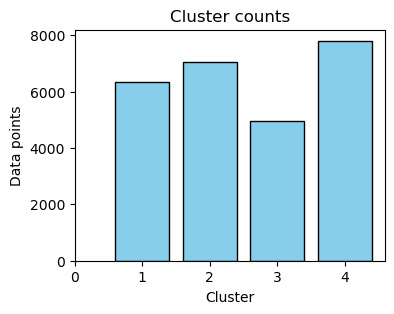

In [44]:
# Bar chart with data in each cluster
cluster, counts = np.unique(clustered_data['cluster'], return_counts=True)
plt.figure(figsize=(4, 3))
plt.bar(cluster, counts, color='skyblue', edgecolor='black')
plt.title('Cluster counts')
plt.xlabel('Cluster')
plt.ylabel('Data points')
plt.xticks(ticks=np.arange(5), labels=np.arange(0, 5))
plt.show()


SIGNIFICANT difference in pain_level levels between the clusters accoring to ANOVA.
                   sum_sq       df           F         PR(>F)
C(cluster)    3695.356937      3.0  188.196276  6.009644e-120
Residual    105070.383737  16053.0         NaN            NaN


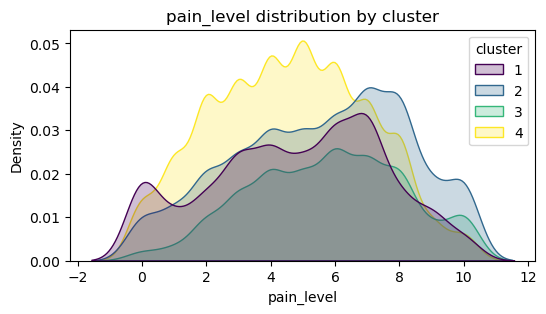




SIGNIFICANT difference in period_intensity levels between the clusters accoring to ANOVA.
                  sum_sq      df          F        PR(>F)
C(cluster)    308.116769     3.0  51.967314  2.729399e-33
Residual    17634.968926  8923.0        NaN           NaN


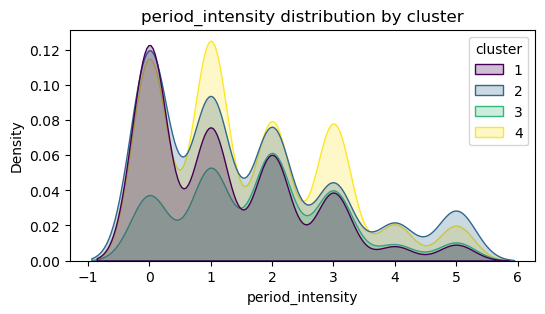




SIGNIFICANT difference in overall_pain levels between the clusters accoring to ANOVA.
                 sum_sq      df          F        PR(>F)
C(cluster)    31.902621     3.0  22.384886  2.876945e-14
Residual    1007.131277  2120.0        NaN           NaN


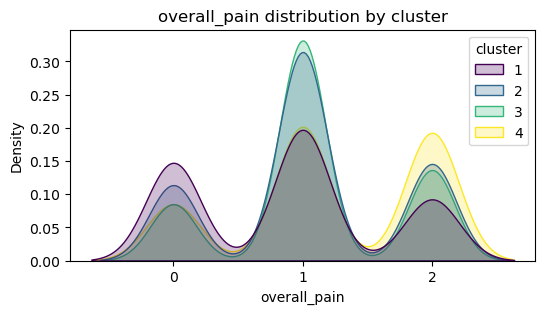




SIGNIFICANT difference in bloating levels between the clusters accoring to ANOVA.
                 sum_sq       df           F        PR(>F)
C(cluster)   192.024391      3.0  125.919011  2.692508e-80
Residual    6053.675432  11909.0         NaN           NaN


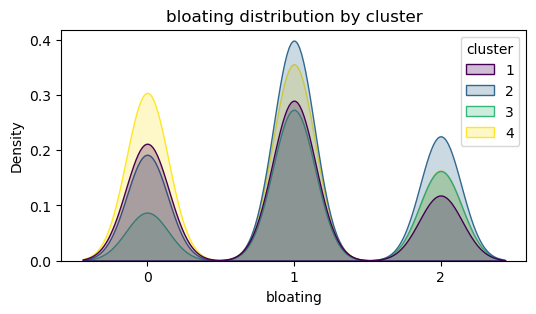




SIGNIFICANT difference in appetite_loss levels between the clusters accoring to ANOVA.
                 sum_sq      df          F        PR(>F)
C(cluster)    65.745152     3.0  40.946152  4.569442e-26
Residual    2204.020981  4118.0        NaN           NaN


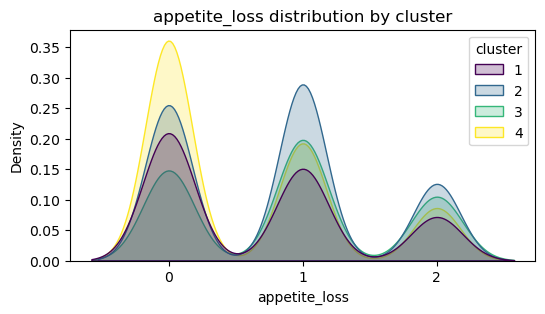




SIGNIFICANT difference in tiredness levels between the clusters accoring to ANOVA.
                 sum_sq       df           F        PR(>F)
C(cluster)   183.480337      3.0  115.333742  1.477168e-73
Residual    5942.938894  11207.0         NaN           NaN


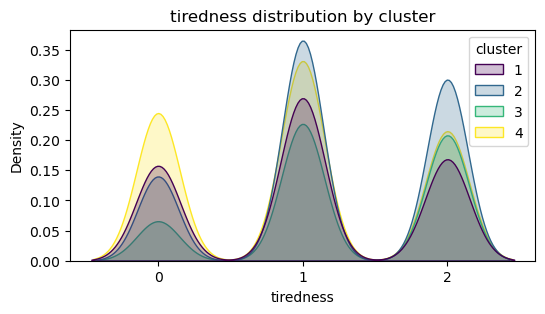




SIGNIFICANT difference in fever levels between the clusters accoring to ANOVA.
                sum_sq      df          F        PR(>F)
C(cluster)   19.529155     3.0  18.127321  1.427797e-11
Residual    584.273420  1627.0        NaN           NaN


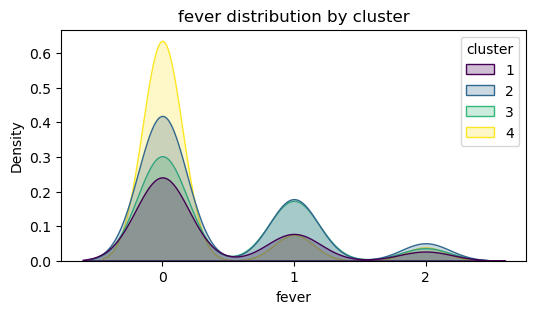




SIGNIFICANT difference in steps levels between the clusters accoring to ANOVA.
                  sum_sq      df         F    PR(>F)
C(cluster)  2.663875e+08     3.0  4.317323  0.004849
Residual    3.301057e+10  1605.0       NaN       NaN


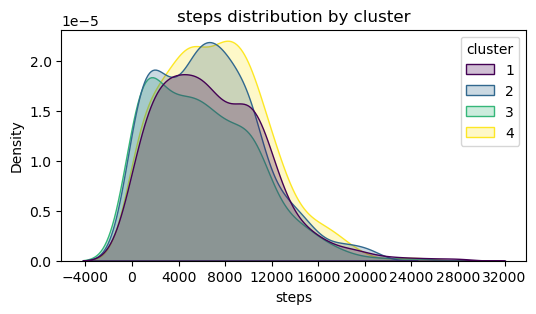




NO significant difference in weight levels between the clusters accoring to ANOVA.
                  sum_sq      df         F    PR(>F)
C(cluster)  4.298149e+03     3.0  0.854268  0.464219
Residual    3.475009e+06  2072.0       NaN       NaN


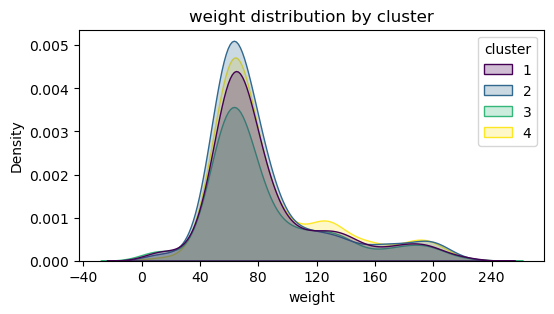




SIGNIFICANT difference in backaches levels between the clusters accoring to ANOVA.
                 sum_sq       df           F        PR(>F)
C(cluster)   200.808208      3.0  136.571235  9.706747e-87
Residual    4957.547163  10115.0         NaN           NaN


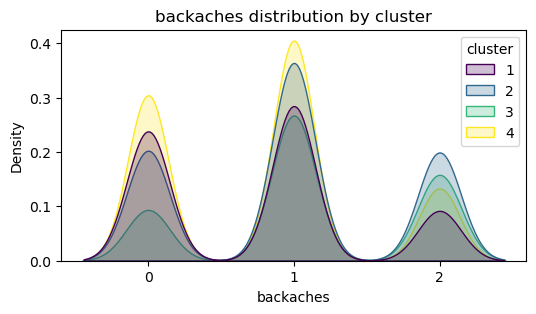




SIGNIFICANT difference in bodyaches levels between the clusters accoring to ANOVA.
                 sum_sq      df          F        PR(>F)
C(cluster)   207.540896     3.0  143.52147  1.191526e-90
Residual    3967.993222  8232.0        NaN           NaN


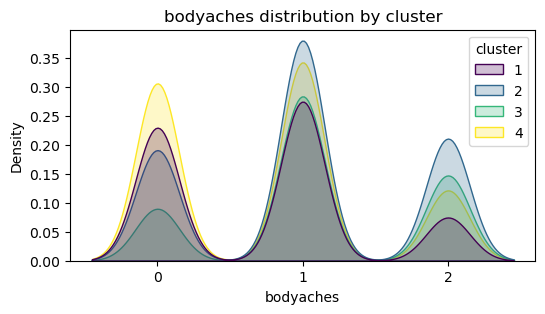




SIGNIFICANT difference in stomach_cramps levels between the clusters accoring to ANOVA.
                 sum_sq      df           F        PR(>F)
C(cluster)   229.869638     3.0  141.961185  5.294068e-90
Residual    5175.100233  9588.0         NaN           NaN


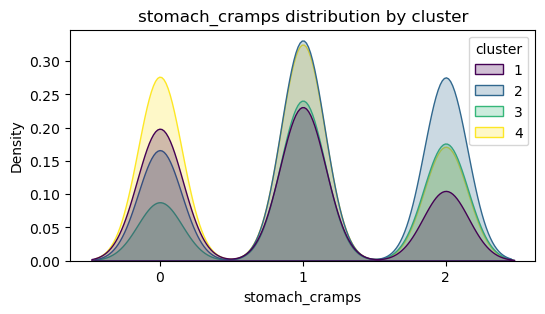




SIGNIFICANT difference in headache levels between the clusters accoring to ANOVA.
                 sum_sq      df          F        PR(>F)
C(cluster)   102.113079     3.0  70.843754  2.940329e-45
Residual    4166.081272  8671.0        NaN           NaN


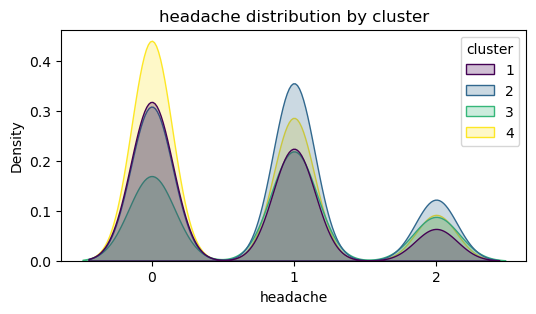




SIGNIFICANT difference in indigestion levels between the clusters accoring to ANOVA.
                 sum_sq      df          F        PR(>F)
C(cluster)    36.576584     3.0  25.505781  2.659366e-16
Residual    1526.307995  3193.0        NaN           NaN


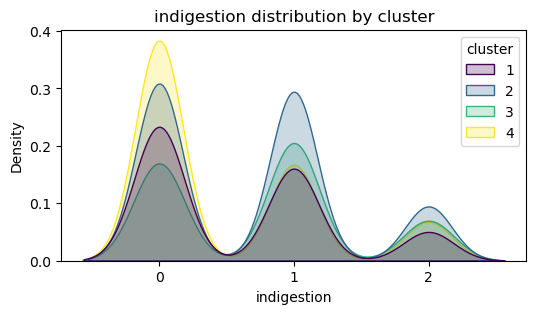




SIGNIFICANT difference in constipation levels between the clusters accoring to ANOVA.
                 sum_sq      df          F        PR(>F)
C(cluster)    42.557003     3.0  27.895471  6.681780e-18
Residual    2903.194442  5709.0        NaN           NaN


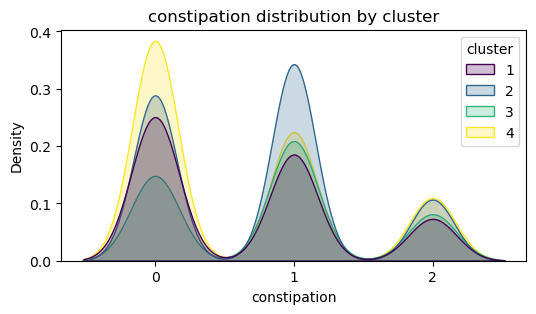




SIGNIFICANT difference in diarrhea levels between the clusters accoring to ANOVA.
                 sum_sq      df          F        PR(>F)
C(cluster)    54.559194     3.0  35.450072  1.334551e-22
Residual    2026.919946  3951.0        NaN           NaN


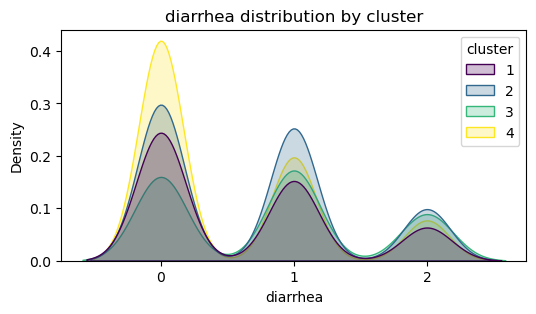




SIGNIFICANT difference in nausea levels between the clusters accoring to ANOVA.
                 sum_sq      df          F        PR(>F)
C(cluster)   116.020091     3.0  76.572201  9.344595e-49
Residual    3655.606117  7238.0        NaN           NaN


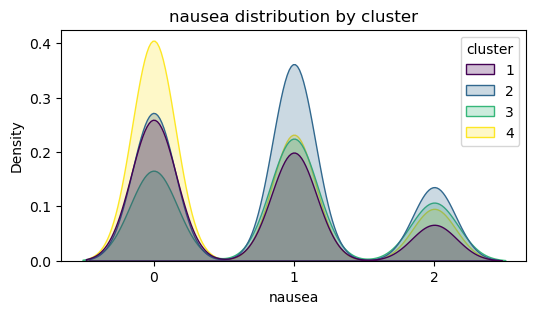




SIGNIFICANT difference in vomiting levels between the clusters accoring to ANOVA.
                sum_sq      df         F   PR(>F)
C(cluster)   11.665664     3.0  7.944046  0.00003
Residual    690.185114  1410.0       NaN      NaN


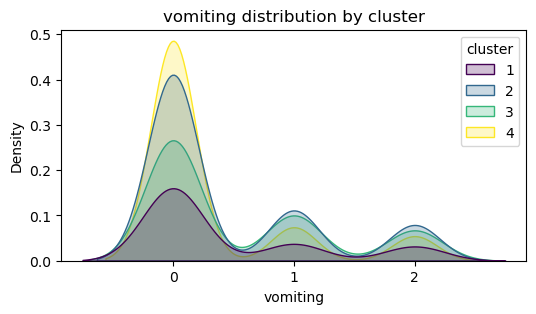




SIGNIFICANT difference in temperature levels between the clusters accoring to ANOVA.
                sum_sq     df        F   PR(>F)
C(cluster)    6.064093    3.0  4.92274  0.00222
Residual    210.236295  512.0      NaN      NaN


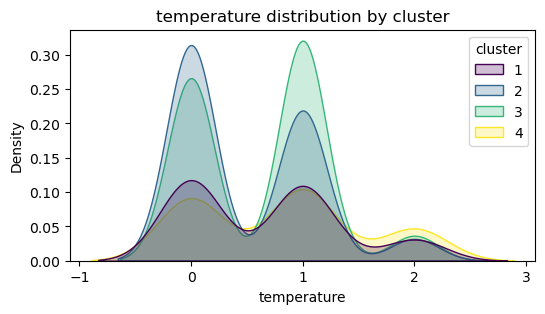




SIGNIFICANT difference in hot_flashes levels between the clusters accoring to ANOVA.
                 sum_sq      df          F        PR(>F)
C(cluster)   103.321981     3.0  67.356858  2.302105e-42
Residual    1826.421867  3572.0        NaN           NaN


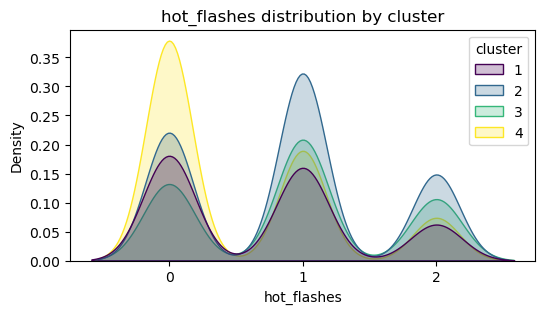




SIGNIFICANT difference in insomnia levels between the clusters accoring to ANOVA.
                 sum_sq      df          F        PR(>F)
C(cluster)    76.538491     3.0  45.678894  4.364117e-29
Residual    2598.819465  4653.0        NaN           NaN


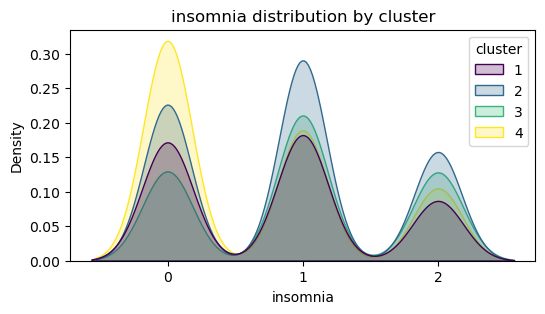




NO significant difference in sleep levels between the clusters accoring to ANOVA.
                  sum_sq      df         F   PR(>F)
C(cluster)  2.340397e+04     3.0  0.750114  0.52228
Residual    1.583949e+07  1523.0       NaN      NaN


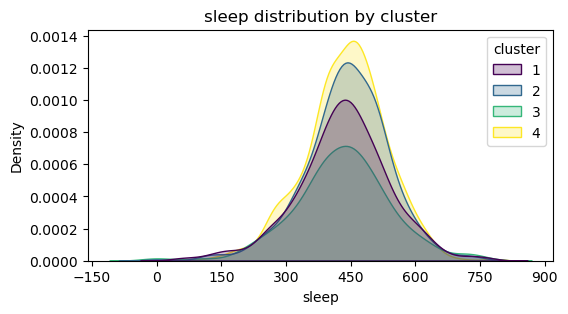

In [46]:
# List of variables to plot
variables = ['pain_level', 'period_intensity', 'overall_pain', 'bloating', 'appetite_loss', 'tiredness', 'fever', 
             'steps', 'weight' ,'backaches','bodyaches', 'stomach_cramps', 'headache', 'indigestion', 'constipation',
             'diarrhea', 'nausea', 'vomiting', 'temperature', 'hot_flashes', 'insomnia', 'sleep'] 
       
# Create distribution plots and ANOVA for each variable of interest by cluster
for var in variables:

    # ANOVA
    anova_model = ols(f'{var} ~ C(cluster)', data=clustered_data).fit()
    anova_results = anova_lm(anova_model, typ=2)
    # Interpretation
    alpha = 0.05
    p_value = anova_results['PR(>F)']['C(cluster)']
    
    if p_value < alpha:
        print(f'\nSIGNIFICANT difference in {var} levels between the clusters accoring to ANOVA.')
    else:
        print(f'\nNO significant difference in {var} levels between the clusters accoring to ANOVA.')

    print(anova_results)

    plt.figure(figsize=(6, 3))
    sn.kdeplot(data=clustered_data, x=var, hue='cluster', fill=True, palette='viridis')
    plt.title(f'{var} distribution by cluster')
    plt.xlabel(var)
    plt.ylabel('Density')
    
    from matplotlib.ticker import MaxNLocator
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.savefig(f'fig/cluster_dist_{var}.png', dpi=300)  
    plt.show()
    print('\n')

In [ ]:
#clustered_data.columns

In [48]:
clustered_data.head()

,period,sex,period_intensity,pain_level,backaches,bodyaches,stomach_cramps,joint_pains,tender_breasts,overall_pain,...,temperature,fever,hot_flashes,short_of_breath,coughing,insomnia,sleep,weight,steps,cluster
0,0,0,NaN,NaN,2.0,2.0,1.0,2.0,1.0,2.0,...,0.0,0.0,NaN,1.0,NaN,0.0,NaN,NaN,NaN,3
1,1,0,0.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,10000.0,3
2,0,1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
3,0,0,NaN,NaN,0.0,1.0,0.0,0.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1
4,0,0,NaN,NaN,0.0,1.0,0.0,0.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [50]:
# Drop columns with less significance to endometriosis
cluster_short = clustered_data.drop(columns=['sex', 'period', 'sleep', 'weight', 'steps', 'tender_breasts', 'dizziness', 'pins_and_needles', 'joint_pains', 'short_of_breath', 'headache', 'nausea', 'temperature', 'hot_flashes', 'vomiting', 'coughing', 'cravings_salty', 'cravings_sweet', 'acne', 'skin_changes'])

In [52]:
# Group by cluster and get mean for each column
cluster_mean = cluster_short.groupby('cluster').mean()
cluster_mean = cluster_mean.reset_index()
cluster_mean = cluster_mean.round(2)
cluster_mean

,cluster,period_intensity,pain_level,backaches,bodyaches,stomach_cramps,overall_pain,indigestion,bloating,constipation,diarrhea,appetite_loss,tiredness,fever,insomnia
0,1,1.24,4.79,0.76,0.73,0.82,0.87,0.59,0.85,0.65,0.61,0.68,1.02,0.38,0.81
1,2,1.58,5.56,1.00,1.03,1.14,1.06,0.69,1.04,0.75,0.69,0.81,1.20,0.43,0.90
2,3,1.82,5.74,1.12,1.11,1.18,1.09,0.78,1.14,0.85,0.83,0.90,1.28,0.48,1.00
3,4,1.60,4.60,0.80,0.76,0.86,1.22,0.49,0.83,0.62,0.51,0.57,0.96,0.20,0.65


In [54]:
# Custom colours for grouped symptoms
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    color_mapping = {
        
        # Blues
        'sex': '#4682B4',
        'period': '#000080',
        'skin_changes': '#87CEFA',
        'weight': '#4169E1',
        'sleep': '#000080',
        'water': '#8FBC8F',
        'steps': '#4682B4',

        # Purples
        'tiredness':"#9370DB", 
        'dizziness':"#9932CC", 
        'pins_and_needles':'#4169E1',
        'insomnia':'#DA70D6',
        'hot_flashes': '#8A2BE2',
        'acne': '#9400D3',
        'skin_changes': '#9400D3',
        'fever': '#C9A0DC',
        'temperature': '#E6E6FA',
        'short_of_breath': '#B19CD9',
        'coughing': '#B19CD9',
        
        # Reds
        'pain_level': '#DC143C',
        'period_intensity': '#FF6347',
        'overall_pain':"#B22222",   
        'backaches': '#CD5C5C', 
        'bodyaches': '#FA8072',
        'stomach_cramps': '#E9967A' , 
        'joint_pains':'#FF7F50', 
        'tender_breasts': '#F08080', 
        'headache':"#B22222", 

        # Browns
        'indigestion':"#A0522D",
        'bloating':"#8B4513", 
        'constipation':'brown', 
        'diarrhea':'#D2691E',
        'nausea':'#F4A460', 
        'vomiting':'#E69F00', 
        'appetite_loss':'#BC8F8F', 
        'cravings_salty':"#B8860B", 
        'cravings_sweet': "#DEB887", 
        
    }
    return color_mapping.get(word, "black")  


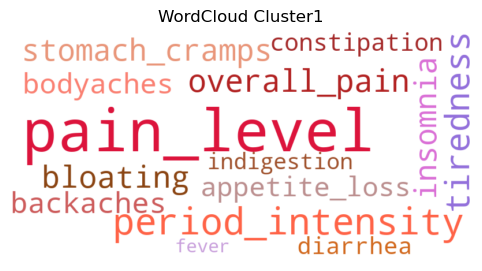

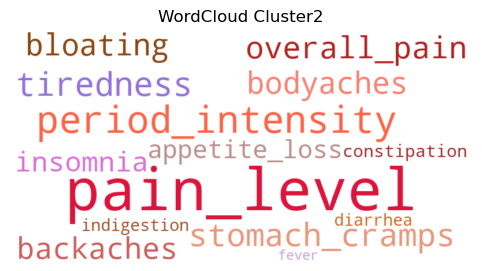

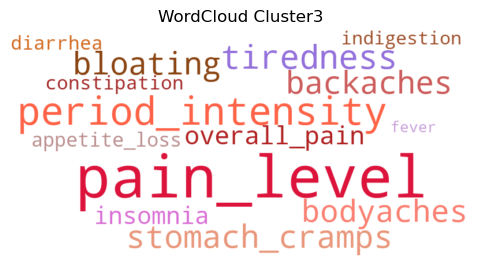

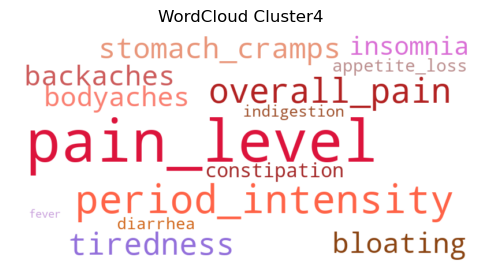

In [66]:
# Create WordCloud for each cluster
def create_wordcloud(row, title, var):
    # Dictionary with column names as words and values as frequencies
    col_value = row.to_dict()
    
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate_from_frequencies(col_value)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.savefig(f'fig/wordcloud_{var}.png', dpi=300)  
    plt.show()

for index, row in cluster_mean.iterrows():
    create_wordcloud(row.drop('cluster'), title=f'WordCloud Cluster{round(row["cluster"])}', var=round(row["cluster"]))

In [57]:
cluster_short = cluster_short.fillna(0)
cluster_sum = cluster_short.groupby('cluster').sum()
cluster_sum = cluster_sum.reset_index()
cluster_sum

,cluster,period_intensity,pain_level,backaches,bodyaches,stomach_cramps,overall_pain,indigestion,bloating,constipation,diarrhea,appetite_loss,tiredness,fever,insomnia
0,1,2490.0,17397.0,1750.0,1318.0,1690.0,430.0,390.0,2307.0,817.0,515.0,583.0,2622.0,108.0,779.0
1,2,4244.0,24914.0,2851.0,2495.0,3218.0,607.0,680.0,3558.0,1247.0,785.0,984.0,3849.0,210.0,1245.0
2,3,2625.0,15167.0,2222.0,1811.0,2215.0,576.0,524.0,2578.0,928.0,681.0,805.0,2677.0,190.0,1013.0
3,4,4461.0,24391.0,2376.0,1803.0,2452.0,649.0,429.0,2921.0,1056.0,584.0,660.0,3216.0,94.0,840.0


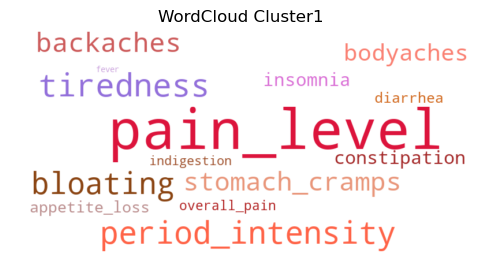

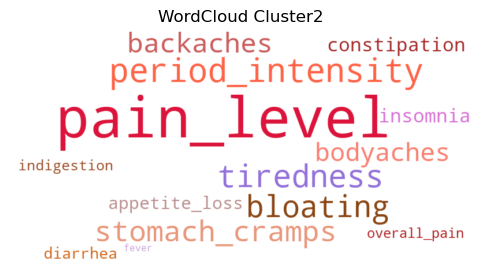

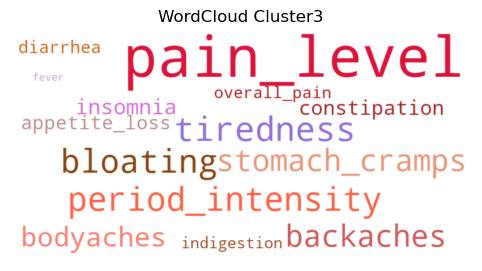

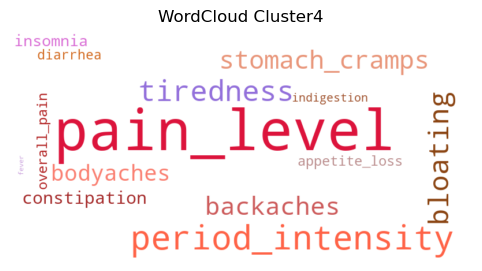

In [68]:
# Create WordCloud for each cluster
def create_wordcloud(row, title, var):
    # Dictionary with column names as words and values as frequencies
    col_value = row.to_dict()
    
    # Generate the word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate_from_frequencies(col_value)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 3))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.savefig(f'fig/wordcloud_sum_{var}.png', dpi=300)  
    plt.show()

for index, row in cluster_sum.iterrows():
    create_wordcloud(row.drop('cluster'), title=f'WordCloud Cluster{round(row["cluster"])}', var=round(row["cluster"]))

### No discernable difference between WordClouds clusters based on variable means